# Polynomial Features and Interaction Terms

## Overview

Linear models can model **non-linear relationships** by creating polynomial features and interaction terms from the original features. This transforms the feature space while keeping the model linear in its parameters.

## Mathematical Foundation

### Original Linear Model
\[
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon
\]

### Polynomial Features (degree=2)
\[
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1^2 + \beta_4 x_1x_2 + \beta_5 x_2^2 + \epsilon
\]

**Key Insight**: The model is still linear in coefficients \(\beta\), but non-linear in original features \(x\).

### Feature Expansion

For input \([x_1, x_2]\) with degree=2:
\[
[x_1, x_2] \rightarrow [1, x_1, x_2, x_1^2, x_1x_2, x_2^2]
\]

**Number of features**: For \(n\) original features and degree \(d\):
\[
\text{New features} = \binom{n + d}{d} = \frac{(n+d)!}{n! \cdot d!}
\]

## Topics Covered

1. Polynomial features for single variables
2. Interaction terms between multiple features
3. Feature explosion and regularization
4. Bias-variance tradeoff with polynomial degree
5. Real-world applications
6. Best practices and pitfalls
7. Custom feature engineering

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_regression, load_diabetes
from itertools import combinations

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Polynomial Features: Single Variable

### 1.1 Understanding Polynomial Transformation

In [2]:
# Simple example to understand transformation
X_simple = np.array([[2], [3], [4]])

print("Polynomial Feature Transformation Demo")
print("="*70)
print(f"Original features: {X_simple.flatten()}\n")

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly = poly.fit_transform(X_simple)
    
    print(f"Degree {degree}:")
    print(f"  Feature names: {poly.get_feature_names_out(['x'])}")
    print(f"  Shape: {X_simple.shape} → {X_poly.shape}")
    print(f"  Example (x=2): {X_poly[0]}")
    print()

Polynomial Feature Transformation Demo
Original features: [2 3 4]

Degree 1:
  Feature names: ['1' 'x']
  Shape: (3, 1) → (3, 2)
  Example (x=2): [1. 2.]

Degree 2:
  Feature names: ['1' 'x' 'x^2']
  Shape: (3, 1) → (3, 3)
  Example (x=2): [1. 2. 4.]

Degree 3:
  Feature names: ['1' 'x' 'x^2' 'x^3']
  Shape: (3, 1) → (3, 4)
  Example (x=2): [1. 2. 4. 8.]



### 1.2 Fitting Non-linear Data

Non-linear Data: y = sin(x) + noise
Data shape: (80, 1)
X range: [0.03, 4.93]
y range: [-1.15, 1.10]


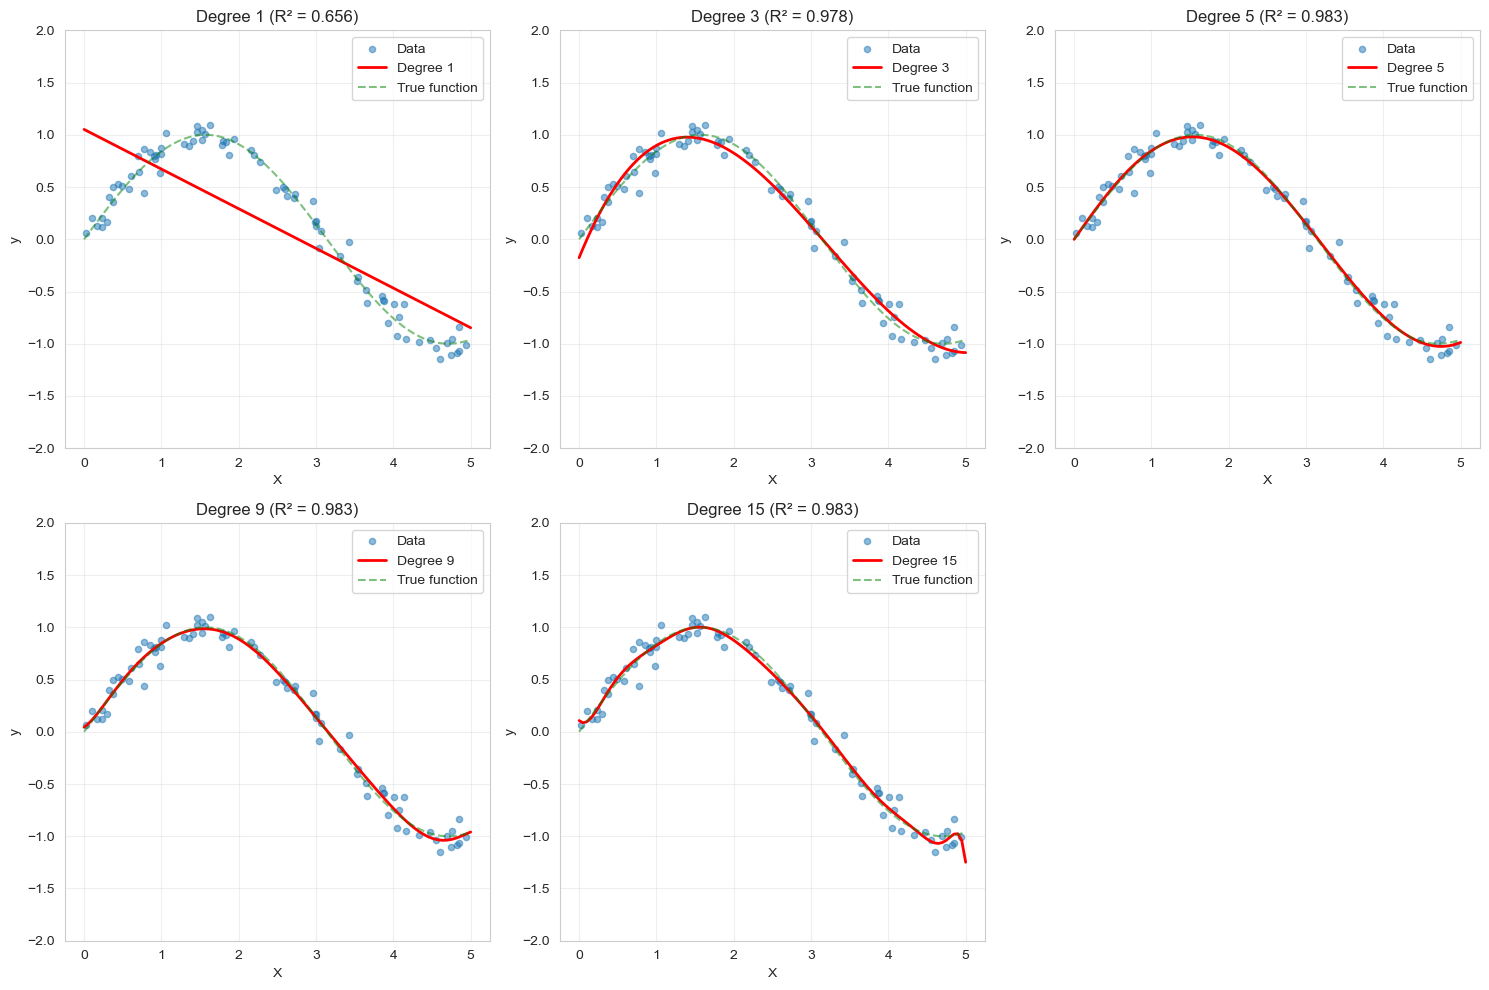


💡 Observations:
  - Degree 1 (linear): Underfitting
  - Degree 3-5: Good fit
  - Degree 15: Overfitting (wild oscillations)


In [3]:
# Generate non-linear data
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(80) * 0.1

print("Non-linear Data: y = sin(x) + noise")
print("="*70)
print(f"Data shape: {X.shape}")
print(f"X range: [{X.min():.2f}, {X.max():.2f}]")
print(f"y range: [{y.min():.2f}, {y.max():.2f}]")

# Try different polynomial degrees
degrees = [1, 3, 5, 9, 15]
X_test = np.linspace(0, 5, 100).reshape(-1, 1)

plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees, 1):
    plt.subplot(2, 3, i)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_test_poly = poly.transform(X_test)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_test_poly)
    
    # Calculate R²
    y_train_pred = model.predict(X_poly)
    r2 = r2_score(y, y_train_pred)
    
    # Plot
    plt.scatter(X, y, alpha=0.5, s=20, label='Data')
    plt.plot(X_test, y_pred, 'r-', linewidth=2, label=f'Degree {degree}')
    plt.plot(X_test, np.sin(X_test), 'g--', alpha=0.5, linewidth=1.5, label='True function')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Degree {degree} (R² = {r2:.3f})')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.ylim(-2, 2)

plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("  - Degree 1 (linear): Underfitting")
print("  - Degree 3-5: Good fit")
print("  - Degree 15: Overfitting (wild oscillations)")

### 1.3 Bias-Variance Tradeoff

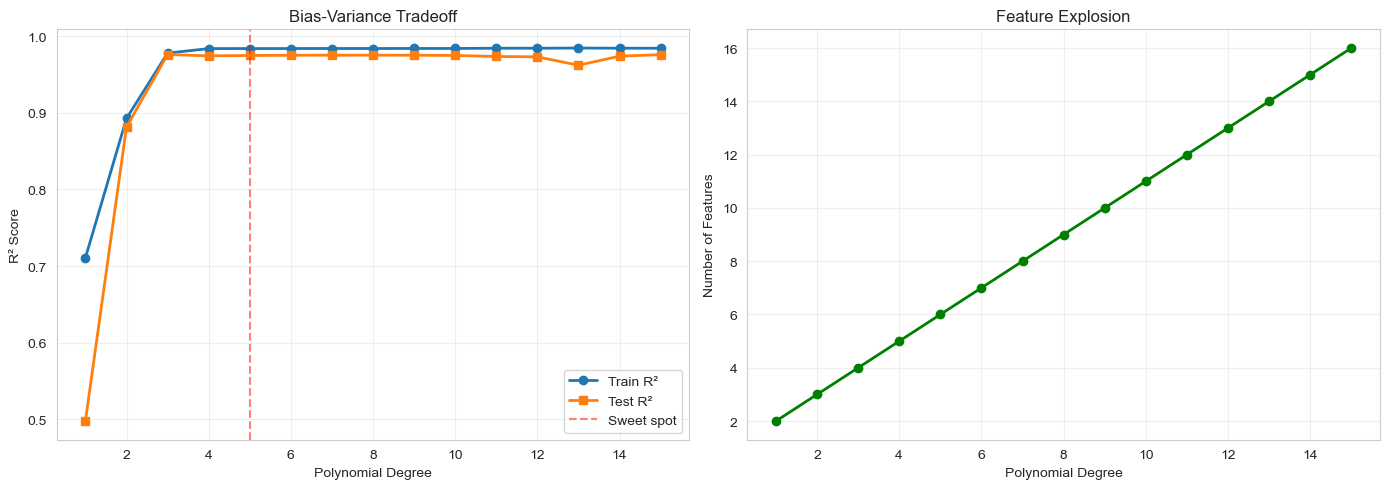


Bias-Variance Analysis:
Optimal degree: 3
Test R² at optimal: 0.9761
Features at optimal: 4

⚠️ At degree 15: 16 features for 56 samples!


In [4]:
# Split data
X_train, X_test_split, y_train, y_test_split = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Evaluate different degrees
degrees_eval = range(1, 16)
train_scores = []
test_scores = []
n_features = []

for degree in degrees_eval:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test_split)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    train_scores.append(model.score(X_train_poly, y_train))
    test_scores.append(model.score(X_test_poly, y_test_split))
    n_features.append(X_train_poly.shape[1])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scores vs degree
axes[0].plot(degrees_eval, train_scores, 'o-', label='Train R²', linewidth=2)
axes[0].plot(degrees_eval, test_scores, 's-', label='Test R²', linewidth=2)
axes[0].axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Sweet spot')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Bias-Variance Tradeoff')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of features
axes[1].plot(degrees_eval, n_features, 'o-', color='green', linewidth=2)
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Feature Explosion')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal degree
optimal_idx = np.argmax(test_scores)
optimal_degree = list(degrees_eval)[optimal_idx]

print("\nBias-Variance Analysis:")
print("="*70)
print(f"Optimal degree: {optimal_degree}")
print(f"Test R² at optimal: {test_scores[optimal_idx]:.4f}")
print(f"Features at optimal: {n_features[optimal_idx]}")
print(f"\n⚠️ At degree 15: {n_features[-1]} features for {len(X_train)} samples!")

## 2. Polynomial Features: Multiple Variables

### 2.1 Feature Explosion with Multiple Variables

In [5]:
# Demonstrate feature explosion
print("Feature Explosion with Multiple Variables")
print("="*70)
print(f"{'n_features':<12} {'degree':<8} {'new_features':<15} {'ratio':<10}")
print("-"*70)

for n_features_orig in [2, 5, 10, 20]:
    for degree in [2, 3, 4]:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_dummy = np.random.rand(10, n_features_orig)
        X_transformed = poly.fit_transform(X_dummy)
        n_new = X_transformed.shape[1]
        ratio = n_new / n_features_orig
        
        print(f"{n_features_orig:<12} {degree:<8} {n_new:<15} {ratio:<10.1f}x")

print("\n⚠️ Warning: Features grow combinatorially!")
print("   Example: 20 features with degree 4 → 10,626 features!")

Feature Explosion with Multiple Variables
n_features   degree   new_features    ratio     
----------------------------------------------------------------------
2            2        5               2.5       x
2            3        9               4.5       x
2            4        14              7.0       x
5            2        20              4.0       x
5            3        55              11.0      x
5            4        125             25.0      x
10           2        65              6.5       x
10           3        285             28.5      x
10           4        1000            100.0     x
20           2        230             11.5      x
20           3        1770            88.5      x
20           4        10625           531.2     x

⚠️ Warning: Features grow combinatorially!
   Example: 20 features with degree 4 → 10,626 features!


### 2.2 Understanding Interaction Terms

In [6]:
# Example with 2 features
X_2d = np.array([[2, 3], [4, 5], [6, 7]])

print("Polynomial Features: 2 Variables")
print("="*70)

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_poly = poly.fit_transform(X_2d)
    feature_names = poly.get_feature_names_out(['x1', 'x2'])
    
    print(f"\nDegree {degree}:")
    print(f"  Features: {list(feature_names)}")
    print(f"  Shape: {X_2d.shape} → {X_poly.shape}")
    
    if degree == 2:
        print(f"\n  Example transformation for [x1=2, x2=3]:")
        print(f"  → [1, 2, 3, 4, 6, 9]")
        print(f"     ↑  ↑  ↑  ↑  ↑   ↑")
        print(f"     1  x1 x2 x1² x1x2 x2²")
        print(f"\n  💡 x1*x2 is the INTERACTION term!")

Polynomial Features: 2 Variables

Degree 1:
  Features: ['1', 'x1', 'x2']
  Shape: (3, 2) → (3, 3)

Degree 2:
  Features: ['1', 'x1', 'x2', 'x1^2', 'x1 x2', 'x2^2']
  Shape: (3, 2) → (3, 6)

  Example transformation for [x1=2, x2=3]:
  → [1, 2, 3, 4, 6, 9]
     ↑  ↑  ↑  ↑  ↑   ↑
     1  x1 x2 x1² x1x2 x2²

  💡 x1*x2 is the INTERACTION term!

Degree 3:
  Features: ['1', 'x1', 'x2', 'x1^2', 'x1 x2', 'x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']
  Shape: (3, 2) → (3, 10)


### 2.3 Interaction Terms in Practice

In [7]:
# Generate data with interaction
np.random.seed(42)
n_samples = 200
X1 = np.random.randn(n_samples)
X2 = np.random.randn(n_samples)

# True relationship includes interaction
y_true = 2 + 3*X1 + 1.5*X2 + 2.5*X1*X2 + np.random.randn(n_samples)*0.5

X_data = np.column_stack([X1, X2])

print("Data with Interaction Term")
print("="*70)
print("True relationship: y = 2 + 3*x1 + 1.5*x2 + 2.5*x1*x2 + noise")
print(f"Data shape: {X_data.shape}\n")

# Split data
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_data, y_true, test_size=0.2, random_state=42
)

# Model WITHOUT interaction
model_no_int = LinearRegression()
model_no_int.fit(X_train_int, y_train_int)
r2_no_int = model_no_int.score(X_test_int, y_test_int)

print("Model WITHOUT interaction (y = β0 + β1*x1 + β2*x2):")
print(f"  Test R²: {r2_no_int:.4f}")
print(f"  Coefficients: {model_no_int.coef_}")

# Model WITH interaction (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_int)
X_test_poly = poly.transform(X_test_int)

model_with_int = LinearRegression()
model_with_int.fit(X_train_poly, y_train_int)
r2_with_int = model_with_int.score(X_test_poly, y_test_int)

print(f"\nModel WITH interaction (degree=2 polynomial):")
print(f"  Test R²: {r2_with_int:.4f}")
print(f"  Feature names: {poly.get_feature_names_out(['x1', 'x2'])}")
print(f"  Coefficients: {model_with_int.coef_}")

print(f"\n✓ Improvement: {(r2_with_int - r2_no_int):.4f}")
print(f"  The interaction term (x1*x2) captures the true relationship!")

Data with Interaction Term
True relationship: y = 2 + 3*x1 + 1.5*x2 + 2.5*x1*x2 + noise
Data shape: (200, 2)

Model WITHOUT interaction (y = β0 + β1*x1 + β2*x2):
  Test R²: 0.5101
  Coefficients: [2.89991837 1.05750488]

Model WITH interaction (degree=2 polynomial):
  Test R²: 0.9833
  Feature names: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']
  Coefficients: [2.94380768 1.49566093 0.02360166 2.53405998 0.01889213]

✓ Improvement: 0.4733
  The interaction term (x1*x2) captures the true relationship!


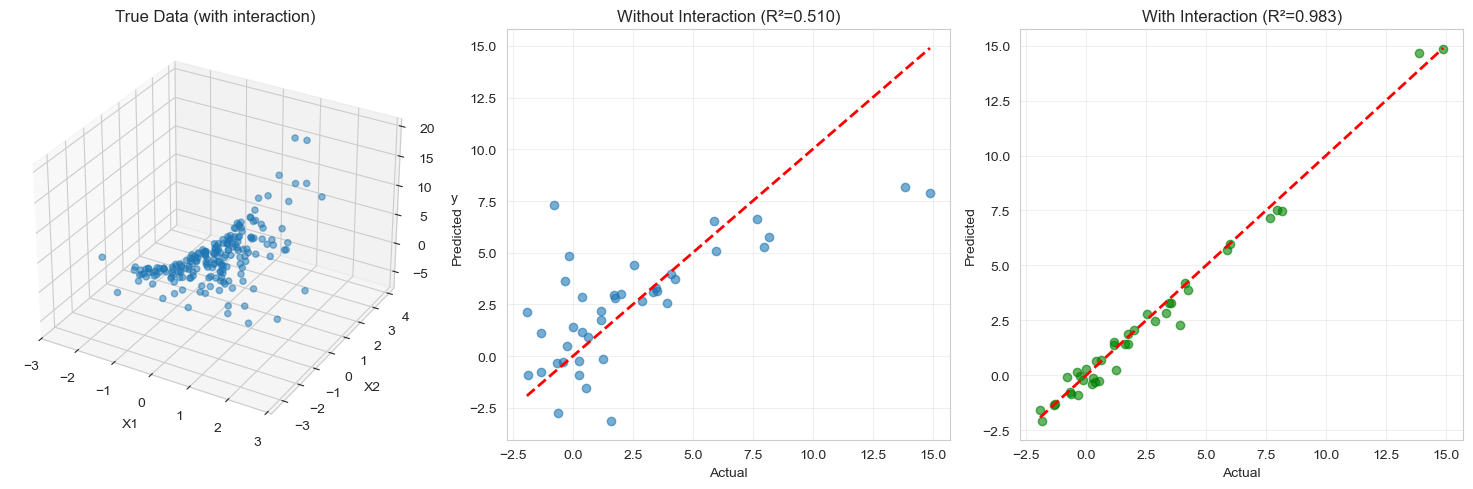

In [8]:
# Visualize interaction effect
fig = plt.figure(figsize=(15, 5))

# 3D scatter plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X1, X2, y_true, alpha=0.5, s=20)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('y')
ax1.set_title('True Data (with interaction)')

# Predictions without interaction
ax2 = fig.add_subplot(132)
y_pred_no_int = model_no_int.predict(X_test_int)
ax2.scatter(y_test_int, y_pred_no_int, alpha=0.6)
ax2.plot([y_test_int.min(), y_test_int.max()], 
         [y_test_int.min(), y_test_int.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Without Interaction (R²={r2_no_int:.3f})')
ax2.grid(alpha=0.3)

# Predictions with interaction
ax3 = fig.add_subplot(133)
y_pred_with_int = model_with_int.predict(X_test_poly)
ax3.scatter(y_test_int, y_pred_with_int, alpha=0.6, color='green')
ax3.plot([y_test_int.min(), y_test_int.max()], 
         [y_test_int.min(), y_test_int.max()], 'r--', lw=2)
ax3.set_xlabel('Actual')
ax3.set_ylabel('Predicted')
ax3.set_title(f'With Interaction (R²={r2_with_int:.3f})')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Polynomial Features + Regularization

### 3.1 The Need for Regularization

In [9]:
# Generate complex data
X_comp, y_comp = make_regression(
    n_samples=100, n_features=5, n_informative=3, noise=10, random_state=42
)

X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(
    X_comp, y_comp, test_size=0.3, random_state=42
)

print("Polynomial Features + Regularization")
print("="*70)
print(f"Original features: {X_comp.shape[1]}")

results = []

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_comp)
    X_test_poly = poly.transform(X_test_comp)
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    
    print(f"\nDegree {degree}: {X_train_poly.shape[1]} features")
    
    # Linear Regression (no regularization)
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train_comp)
    train_r2_lr = lr.score(X_train_scaled, y_train_comp)
    test_r2_lr = lr.score(X_test_scaled, y_test_comp)
    
    # Ridge
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train_comp)
    train_r2_ridge = ridge.score(X_train_scaled, y_train_comp)
    test_r2_ridge = ridge.score(X_test_scaled, y_test_comp)
    
    # Lasso
    lasso = Lasso(alpha=0.1, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_comp)
    train_r2_lasso = lasso.score(X_train_scaled, y_train_comp)
    test_r2_lasso = lasso.score(X_test_scaled, y_test_comp)
    n_nonzero = np.sum(lasso.coef_ != 0)
    
    print(f"  Linear Reg:  Train R²={train_r2_lr:.3f}, Test R²={test_r2_lr:.3f}")
    print(f"  Ridge:       Train R²={train_r2_ridge:.3f}, Test R²={test_r2_ridge:.3f}")
    print(f"  Lasso:       Train R²={train_r2_lasso:.3f}, Test R²={test_r2_lasso:.3f}, Features={n_nonzero}")
    
    results.append({
        'Degree': degree,
        'N_Features': X_train_poly.shape[1],
        'LR_Test': test_r2_lr,
        'Ridge_Test': test_r2_ridge,
        'Lasso_Test': test_r2_lasso,
        'Lasso_Selected': n_nonzero
    })

results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("Summary:")
print(results_df.to_string(index=False))

Polynomial Features + Regularization
Original features: 5

Degree 1: 5 features
  Linear Reg:  Train R²=0.986, Test R²=0.987
  Ridge:       Train R²=0.986, Test R²=0.987
  Lasso:       Train R²=0.986, Test R²=0.987, Features=5

Degree 2: 20 features
  Linear Reg:  Train R²=0.987, Test R²=0.987
  Ridge:       Train R²=0.987, Test R²=0.987
  Lasso:       Train R²=0.987, Test R²=0.988, Features=18

Degree 3: 55 features
  Linear Reg:  Train R²=0.996, Test R²=0.731
  Ridge:       Train R²=0.992, Test R²=0.971
  Lasso:       Train R²=0.994, Test R²=0.968, Features=44

Summary:
 Degree  N_Features  LR_Test  Ridge_Test  Lasso_Test  Lasso_Selected
      1           5 0.986850    0.987231    0.987056               5
      2          20 0.986998    0.986755    0.987635              18
      3          55 0.731083    0.971175    0.967611              44


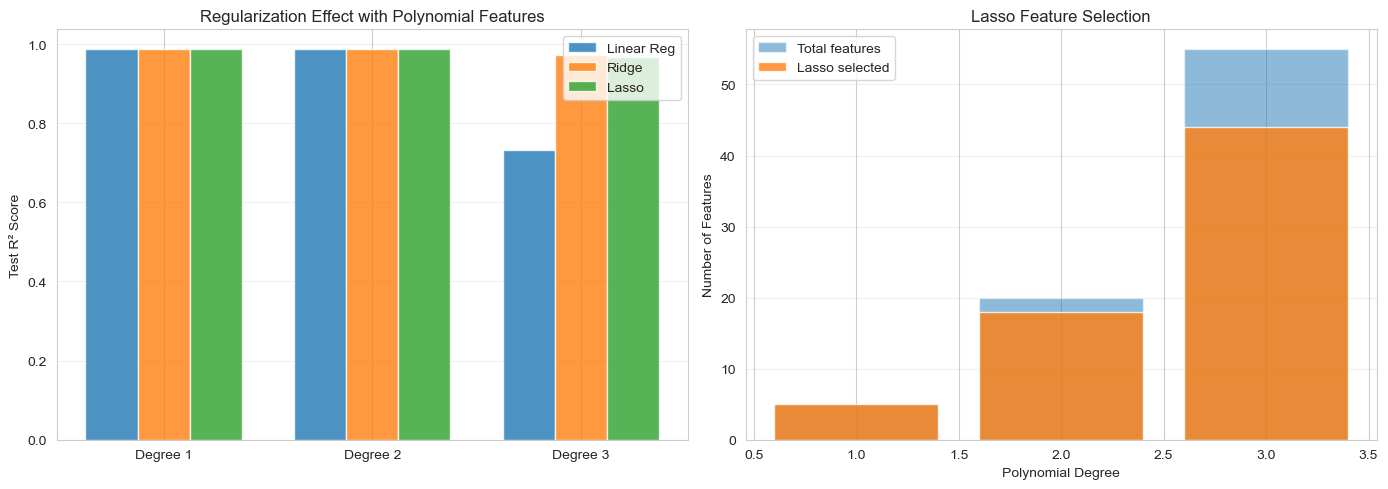


💡 Key Insight: Regularization is ESSENTIAL with polynomial features!


In [10]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test R² comparison
x_pos = np.arange(len(results_df))
width = 0.25

axes[0].bar(x_pos - width, results_df['LR_Test'], width, label='Linear Reg', alpha=0.8)
axes[0].bar(x_pos, results_df['Ridge_Test'], width, label='Ridge', alpha=0.8)
axes[0].bar(x_pos + width, results_df['Lasso_Test'], width, label='Lasso', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"Degree {d}" for d in results_df['Degree']])
axes[0].set_ylabel('Test R² Score')
axes[0].set_title('Regularization Effect with Polynomial Features')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Feature selection by Lasso
axes[1].bar(results_df['Degree'], results_df['N_Features'], alpha=0.5, label='Total features')
axes[1].bar(results_df['Degree'], results_df['Lasso_Selected'], alpha=0.8, label='Lasso selected')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Lasso Feature Selection')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Regularization is ESSENTIAL with polynomial features!")

## 4. Pipeline: Best Practice

### 4.1 Creating a Polynomial Pipeline

In [11]:
# Create pipelines with different configurations
print("Polynomial Regression Pipelines")
print("="*70)

# Pipeline 1: Polynomial + Linear Regression
pipe_lr = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    LinearRegression()
)

# Pipeline 2: Polynomial + Ridge
pipe_ridge = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    Ridge(alpha=1.0)
)

# Pipeline 3: Polynomial + Lasso
pipe_lasso = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10000)
)

pipelines = {
    'Poly + LR': pipe_lr,
    'Poly + Ridge': pipe_ridge,
    'Poly + Lasso': pipe_lasso
}

# Train and evaluate
for name, pipeline in pipelines.items():
    # Fit
    pipeline.fit(X_train_comp, y_train_comp)
    
    # Evaluate
    train_score = pipeline.score(X_train_comp, y_train_comp)
    test_score = pipeline.score(X_test_comp, y_test_comp)
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_score:.4f}")
    print(f"  Test R²: {test_score:.4f}")
    print(f"  Pipeline steps: {[step[0] for step in pipeline.steps]}")

print("\n✓ Pipelines ensure correct preprocessing order!")
print("  1. PolynomialFeatures")
print("  2. StandardScaler")
print("  3. Model")

Polynomial Regression Pipelines

Poly + LR:
  Train R²: 0.9871
  Test R²: 0.9870
  Pipeline steps: ['polynomialfeatures', 'standardscaler', 'linearregression']

Poly + Ridge:
  Train R²: 0.9868
  Test R²: 0.9868
  Pipeline steps: ['polynomialfeatures', 'standardscaler', 'ridge']

Poly + Lasso:
  Train R²: 0.9871
  Test R²: 0.9876
  Pipeline steps: ['polynomialfeatures', 'standardscaler', 'lasso']

✓ Pipelines ensure correct preprocessing order!
  1. PolynomialFeatures
  2. StandardScaler
  3. Model


### 4.2 Tuning Polynomial Degree with Validation Curve

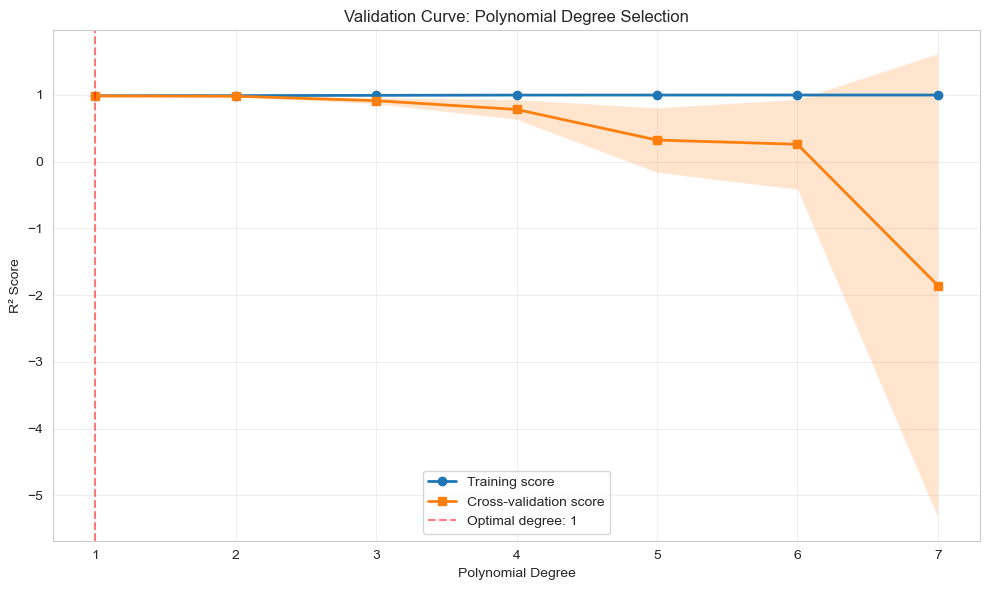


Optimal polynomial degree: 1
Cross-validation R² at optimal: 0.9841


In [12]:
# Use validation curve to find optimal degree
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

# Test different degrees
param_range = range(1, 8)
train_scores, test_scores = validation_curve(
    pipeline, X_comp, y_comp,
    param_name='poly__degree',
    param_range=param_range,
    cv=5,
    scoring='r2'
)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', label='Training score', linewidth=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(param_range, test_mean, 's-', label='Cross-validation score', linewidth=2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2)

# Mark optimal degree
optimal_degree = param_range[np.argmax(test_mean)]
plt.axvline(x=optimal_degree, color='r', linestyle='--', alpha=0.5, 
           label=f'Optimal degree: {optimal_degree}')

plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Validation Curve: Polynomial Degree Selection')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nOptimal polynomial degree: {optimal_degree}")
print(f"Cross-validation R² at optimal: {test_mean[optimal_degree-1]:.4f}")

## 5. Real Dataset: Diabetes with Polynomial Features

### 5.1 Baseline vs Polynomial Models

In [13]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

print("Diabetes Dataset: Polynomial Features Analysis")
print("="*70)
print(f"Original features: {X_diabetes.shape[1]}")
print(f"Feature names: {diabetes.feature_names}\n")

# Test different polynomial degrees
diabetes_results = []

for degree in [1, 2]:
    # Create pipeline
    pipeline = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        Ridge(alpha=1.0)
    )
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_diabetes, y_diabetes, cv=5, scoring='r2')
    
    # Fit and evaluate
    pipeline.fit(X_train_db, y_train_db)
    test_score = pipeline.score(X_test_db, y_test_db)
    
    # Get number of features after transformation
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_transformed = poly.fit_transform(X_diabetes)
    n_features = X_transformed.shape[1]
    
    diabetes_results.append({
        'Degree': degree,
        'N_Features': n_features,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Test_R2': test_score
    })
    
    print(f"Degree {degree}:")
    print(f"  Features: {n_features}")
    print(f"  CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Test R²: {test_score:.4f}\n")

diabetes_df = pd.DataFrame(diabetes_results)
print("="*70)
print(diabetes_df.to_string(index=False))

improvement = diabetes_df.loc[1, 'Test_R2'] - diabetes_df.loc[0, 'Test_R2']
print(f"\nImprovement with degree 2: {improvement:.4f}")

Diabetes Dataset: Polynomial Features Analysis
Original features: 10
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Degree 1:
  Features: 10
  CV R²: 0.4822 (±0.0489)
  Test R²: 0.4541

Degree 2:
  Features: 65
  CV R²: 0.4179 (±0.1165)
  Test R²: 0.4558

 Degree  N_Features  CV_Mean   CV_Std  Test_R2
      1          10 0.482194 0.048859 0.454147
      2          65 0.417872 0.116482 0.455779

Improvement with degree 2: 0.0016


## 6. Custom Feature Engineering

### 6.1 Interaction-Only Features

In [14]:
# Interaction-only (no polynomial terms)
poly_interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_sample = np.array([[1, 2, 3]])
X_full = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_sample)
X_interaction = poly_interaction.fit_transform(X_sample)

print("Interaction-Only Features")
print("="*70)
print(f"Input: {X_sample[0]}\n")

print("Full polynomial (degree=2):")
print(f"  Features: {PolynomialFeatures(degree=2, include_bias=False).fit(X_sample).get_feature_names_out(['x1', 'x2', 'x3'])}")
print(f"  Output: {X_full[0]}\n")

print("Interaction-only (no x²):")
print(f"  Features: {poly_interaction.get_feature_names_out(['x1', 'x2', 'x3'])}")
print(f"  Output: {X_interaction[0]}\n")

print("💡 Interaction-only excludes squared terms (x1², x2², x3²)")
print("   Useful when you only want interactions between different features!")

Interaction-Only Features
Input: [1 2 3]

Full polynomial (degree=2):
  Features: ['x1' 'x2' 'x3' 'x1^2' 'x1 x2' 'x1 x3' 'x2^2' 'x2 x3' 'x3^2']
  Output: [1. 2. 3. 1. 2. 3. 4. 6. 9.]

Interaction-only (no x²):
  Features: ['x1' 'x2' 'x3' 'x1 x2' 'x1 x3' 'x2 x3']
  Output: [1. 2. 3. 2. 3. 6.]

💡 Interaction-only excludes squared terms (x1², x2², x3²)
   Useful when you only want interactions between different features!


### 6.2 Manual Interaction Creation

In [15]:
# Create specific interactions manually
def create_custom_interactions(X, interactions):
    """
    Create specific interaction terms.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
    interactions : list of tuples
        Each tuple contains indices of features to interact
    
    Returns:
    --------
    X_with_interactions : array with original features + interactions
    """
    X_interactions = []
    
    for i, j in interactions:
        X_interactions.append((X[:, i] * X[:, j]).reshape(-1, 1))
    
    if X_interactions:
        return np.hstack([X] + X_interactions)
    return X

# Example
X_example = np.random.rand(100, 4)

# Only create interactions between features 0&1, and 2&3
interactions = [(0, 1), (2, 3)]
X_custom = create_custom_interactions(X_example, interactions)

print("Custom Interaction Creation")
print("="*70)
print(f"Original shape: {X_example.shape}")
print(f"With custom interactions: {X_custom.shape}")
print(f"\nAdded interactions:")
print(f"  - Feature 0 × Feature 1")
print(f"  - Feature 2 × Feature 3")
print(f"\n💡 This gives you full control over which interactions to include!")

Custom Interaction Creation
Original shape: (100, 4)
With custom interactions: (100, 6)

Added interactions:
  - Feature 0 × Feature 1
  - Feature 2 × Feature 3

💡 This gives you full control over which interactions to include!


## Summary and Quick Reference

### Quick Start Template

```python
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Best practice pipeline
model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0)
)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
```

### Key Parameters

**PolynomialFeatures**:
- `degree`: Polynomial degree (typically 2-3)
- `interaction_only`: Only cross-products, no x² terms
- `include_bias`: Add constant term (use False in pipelines)

### When to Use Polynomial Features

✓ **Good for:**
- Non-linear relationships
- Feature interactions matter
- Smooth curves needed
- Small to moderate number of original features

✗ **Not ideal for:**
- Already high-dimensional data (> 50 features)
- Linear relationships
- When interpretability is critical
- Very limited training data

### Feature Count Formula

For \(n\) features and degree \(d\):

| n | degree=2 | degree=3 | degree=4 |
|---|----------|----------|----------|
| 2 | 5 | 9 | 14 |
| 5 | 20 | 55 | 125 |
| 10 | 65 | 285 | 1,000 |
| 20 | 230 | 1,770 | 10,626 |

### Best Practices

1. ✓ Always use pipelines
2. ✓ Standardize after polynomial transform
3. ✓ Use regularization (Ridge/Lasso)
4. ✓ Start with degree=2
5. ✓ Use cross-validation
6. ✓ Check feature explosion
7. ✓ Consider interaction_only
8. ✓ Monitor train vs test gap

### Common Pitfalls

1. ❌ Not standardizing
2. ❌ Using high degrees blindly
3. ❌ No regularization
4. ❌ Standardizing before polynomial
5. ❌ Ignoring feature count
6. ❌ Not using cross-validation
7. ❌ Including bias in pipeline
8. ❌ Overfitting to training data

### Next Steps

- Logistic regression with polynomial features
- Kernel methods (polynomial kernel in SVM)
- Spline regression for smoother curves
- Feature selection with high-dimensional polynomial features